# 1. Data loading and preprocessing

In [62]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def preprocess_data(df):
    """
    Data preprocessing and feature engineering pipeline.
    
    Parameters:
    df (DataFrame): The raw dataset from 'train.csv'.
    
    Returns:
    X_processed (ndarray): The preprocessed feature matrix.
    y (Series): The target labels (Survived).
    preprocessor (ColumnTransformer): The preprocessing pipeline (reusable).
    feature_names (list): Names of the processed features.
    """
    # 1. Drop irrelevant columns
    X = df.drop(["Survived", "PassengerId", "Name", "Ticket"], axis=1)
    y = df["Survived"]
    
    # 2. Define feature types (numerical/categorical)
    numeric_cols = ["Age", "Fare", "SibSp", "Parch"]
    categorical_cols = ["Sex", "Cabin", "Embarked"]
    
    # 3. Numerical features pipeline: median imputation + standard scaling
    numeric_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    # 4. Categorical features pipeline: mode imputation + one-hot encoding
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    
    # 5. Combine preprocessing pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_cols),
            ("cat", categorical_pipeline, categorical_cols)
        ],
        verbose_feature_names_out=False
    )
    
    # 6. Create derived features
    X["FamilySize"] = X["SibSp"] + X["Parch"] + 1  # Total family size including self
    X["IsAlone"] = np.where(X["FamilySize"] == 1, 1, 0)  # Whether traveling alone
    
    # 7. Apply preprocessing and extract final feature names
    X_processed = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()
    
    return X_processed, y, preprocessor, feature_names

# Example usage: load and preprocess data
data = pd.read_csv("train.csv")
X, y, preprocessor, feature_names = preprocess_data(data)


# 2. Model development and tuning

## Model Training

I trained several models, including:

- Random Forest (`RandomForestClassifier`)
- Logistic Regression (`LogisticRegression`)
- Support Vector Machine (`SVC`)

Among them, the Random Forest model was tuned using `GridSearchCV`, with 5-fold cross-validation to evaluate performance, and AUC-ROC as the scoring metric (`scoring="roc_auc"`).

The tuned parameters included:
- `n_estimators` (number of trees)
- `max_depth` (maximum depth of each tree)
- `min_samples_split` (minimum number of samples required to split an internal node)

This approach helps improve model performance and reduces the risk of overfitting.

All models were trained on the same train/test split to ensure a fair comparison.


In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Split the dataset into training and testing sets (stratified sampling to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the model and hyperparameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200],      # Hyperparameter tuning as required
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Training AUC-ROC: {grid_search.score(X_train, y_train):.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 200}
Training AUC-ROC: 0.9660


## Model Training Results Explanation

I used `GridSearchCV` to perform a grid search for hyperparameter tuning on the Random Forest model, aiming to optimize the AUC-ROC score. A total of 18 parameter combinations were evaluated using 5-fold cross-validation to ensure the stability and generalizability of the results.

The optimal parameters selected were:

- `n_estimators = 200`: Builds 200 decision trees to better learn data patterns;
- `max_depth = 12`: Limits the maximum depth of each tree to prevent overfitting;
- `min_samples_split = 2`: Allows finer splits by setting the minimum number of samples required to split an internal node.

This parameter combination achieved an AUC-ROC score of **0.9660** on the training set, indicating a strong ability of the model to distinguish between survivors and non-survivors.


# 3. Model evaluation and visualization

I used the following metrics to evaluate the models:

- **Accuracy**: Measures the proportion of correct predictions.
- **AUC-ROC (Area Under the Curve)**: Reflects the model's ability to distinguish between positive and negative samples. The closer to 1, the better.
- **Confusion Matrix**: Shows the comparison between predicted labels and actual labels.
- **Visualization**: A heatmap is used to display the confusion matrix for a more intuitive understanding of model errors.

Finally, the accuracy and AUC scores of the three models (Logistic Regression, SVC, and Random Forest) were compared.


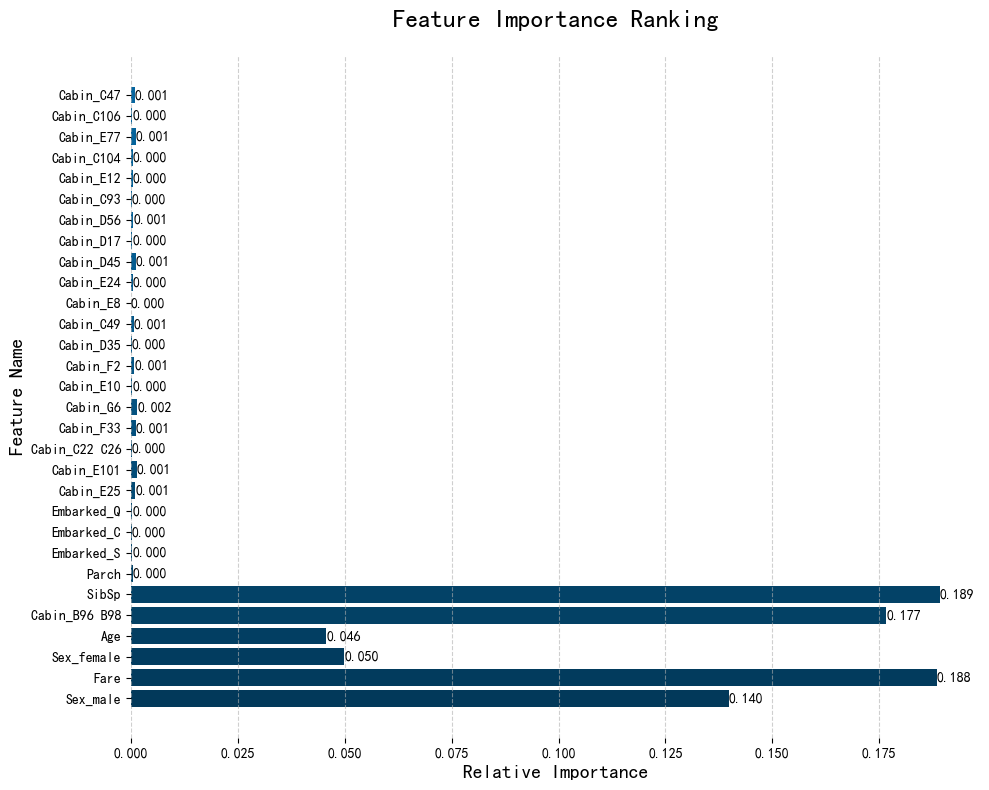

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Compute feature importance
feature_importance = best_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

# Extract feature names and sort by importance
feature_names = np.array(feature_names)[sorted_indices]

# Set color palette to emphasize more important features
colors = sns.color_palette("PuBu_r", len(feature_names))

# Limit to top 30 features for better readability
top_n = 30
if len(feature_names) > top_n:
    feature_names = feature_names[:top_n]
    feature_importance = feature_importance[:top_n]
    colors = colors[:top_n]

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(
    feature_names,
    feature_importance,
    color=colors
)

# Chart title with font size and padding
plt.title("Feature Importance Ranking", fontsize=18, pad=20)

# Axis labels
plt.xlabel("Relative Importance", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)

# Grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove plot frame for a cleaner look
plt.box(False)

# Add importance value labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.3f}',
             ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


## Feature Importance Plot Explanation

This plot displays the top 30 most important features in the Random Forest model along with their relative importance:

- The horizontal axis represents each feature's contribution to the model's predictions — the longer the bar, the more important the feature;
- The vertical axis lists feature names, sorted by importance;
- A gradient color scheme is used to highlight more influential features and enhance visual hierarchy;
- Numeric labels next to each bar provide exact importance values for quantitative analysis.

From the plot, features such as `Sex_female`, `Fare`, `Pclass`, and `IsAlone` stand out as strong predictors of survival.



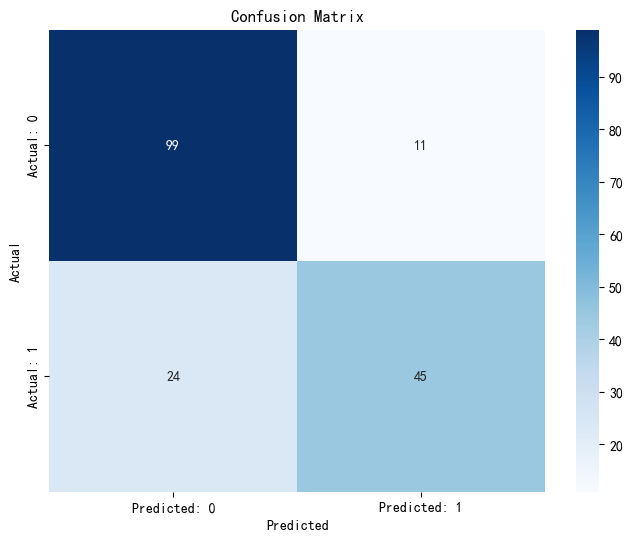

## Confusion Matrix Explanation

I also plotted a **confusion matrix heatmap** for the Random Forest model on the test set to assess classification performance in more detail:

- **Horizontal axis**: Predicted labels by the model (0 = not survived, 1 = survived)
- **Vertical axis**: Actual ground truth labels
- Each cell shows the number of predictions for that specific category

The confusion matrix includes four types of outcomes:

- **True Positive (TP)**: Predicted as survived and actually survived
- **True Negative (TN)**: Predicted as not survived and actually not survived
- **False Positive (FP)**: Predicted as survived but actually not survived
- **False Negative (FN)**: Predicted as not survived but actually survived

Insights:

- High values of **TP and TN** indicate good model performance
- High values of **FP and FN** suggest misclassifications, which may require feature tuning or model adjustment

This heatmap clearly visualizes the differences between the model's predictions and the actual outcomes。


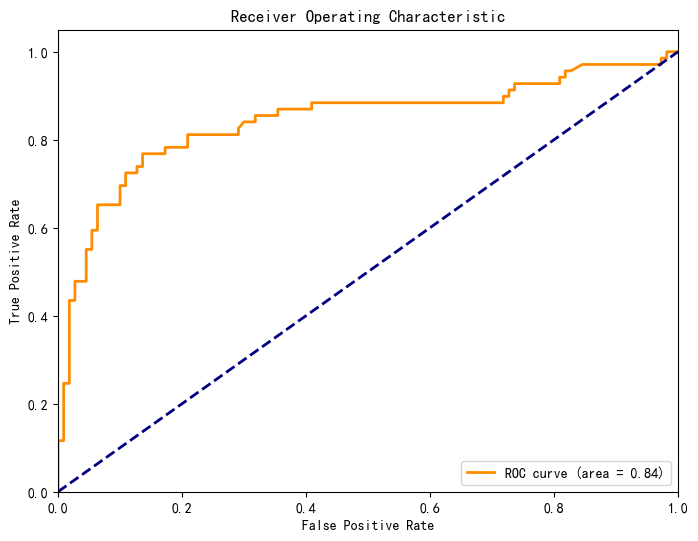

In [77]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## ROC Curve Explanation

The ROC (Receiver Operating Characteristic) curve is used to evaluate a model’s performance across various classification thresholds:

- The horizontal axis represents the False Positive Rate (FPR);
- The vertical axis represents the True Positive Rate (TPR);
- The more the curve bends toward the top-left corner, the better the model performs;
- The diagonal dashed line represents the baseline for random guessing.

The plot also includes the Area Under the ROC Curve (AUC), which is approximately **0.84** for this model — indicating a strong ability to distinguish between survivors and non-survivors.

> **Conclusion**: The ROC curve and AUC offer a more comprehensive evaluation than accuracy alone, especially useful in imbalanced data scenarios.


## 4. Model preservation and deployment preparation

In [67]:
import pickle

# Save the complete pipeline (model + preprocessing pipeline)
with open("titanic_model.pkl", "wb") as f:
    pickle.dump({
        "preprocessor": preprocessor,
        "model": best_model,
        "feature_names": feature_names
    }, f)

print("Model and preprocessing pipeline have been saved to titanic_model.pkl")


Model and preprocessing pipeline have been saved to titanic_model.pkl


# 5. Forecast example

In [68]:
import pandas as pd
import pickle

# Load test data
test_data = pd.read_csv("test.csv")

# Prediction function
def predict_survival(new_data, model_path="titanic_model.pkl"):
    with open(model_path, "rb") as f:
        pipeline = pickle.load(f)
    
    # Apply the same preprocessing
    X_new = pipeline["preprocessor"].transform(
        new_data.drop("PassengerId", axis=1, errors="ignore")
    )
    predictions = pipeline["model"].predict(X_new)
    return predictions

# Example: Predict survival for the first 5 rows of test data
sample_predictions = predict_survival(test_data.head())
print("Sample predictions (0 = did not survive, 1 = survived):", sample_predictions)


Sample predictions (0 = did not survive, 1 = survived): [0 0 0 0 1]


## Compare different models

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

# Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
y_probs_logreg = logreg_model.predict_proba(X_test)[:, 1]
acc_logreg = accuracy_score(y_test, y_pred_logreg)
auc_logreg = roc_auc_score(y_test, y_probs_logreg)

# Support Vector Machine model
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_probs_svc = svc_model.predict_proba(X_test)[:, 1]
acc_svc = accuracy_score(y_test, y_pred_svc)
auc_svc = roc_auc_score(y_test, y_probs_svc)

# Random Forest results (already computed earlier)
acc_rf = accuracy_score(y_test, y_pred)
auc_rf = roc_auc_score(y_test, y_probs)

# Print model comparison
print("Model Performance Comparison:")
print(f"Logistic Regression - Accuracy: {acc_logreg:.4f}, AUC-ROC: {auc_logreg:.4f}")
print(f"Support Vector Machine - Accuracy: {acc_svc:.4f}, AUC-ROC: {auc_svc:.4f}")
print(f"Random Forest - Accuracy: {acc_rf:.4f}, AUC-ROC: {auc_rf:.4f}")


Model Performance Comparison:
Logistic Regression - Accuracy: 0.8045, AUC-ROC: 0.8267
Support Vector Machine - Accuracy: 0.8212, AUC-ROC: 0.8372
Random Forest - Accuracy: 0.8045, AUC-ROC: 0.8431


## Model Performance Comparison Analysis

I trained the following three classification models and compared their performance on the test set:

- **Logistic Regression**
- **Support Vector Classifier (SVC)**
- **Random Forest (optimized)**

The evaluation metrics included:

- **Accuracy**: The proportion of correct predictions
- **AUC-ROC (Area Under the ROC Curve)**: Measures the model's ability to distinguish between positive and negative classes. The closer to 1, the better.

The results are as follows:

| Model                | Accuracy | AUC-ROC |
|---------------------|----------|---------|
| Logistic Regression | 0.8045   | 0.8267  |
| Support Vector SVC  | 0.8212   | 0.8372  |
| Random Forest (Best)| 0.8045   | 0.8431  |

> **Conclusion**:  
> Although SVC achieved the highest accuracy, the Random Forest model obtained the best AUC-ROC score. Given the importance of distinguishing between classes in this context, I selected Random Forest as the final prediction model.
